# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

import time
import os
import copy
import requests
import zipfile
import io

## GPU 설정

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
device

device(type='cuda')

## 데이터 로드 및 확인

In [50]:
URL = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'

res = requests.get(URL)
res.raise_for_status()

z = zipfile.ZipFile(io.BytesIO(res.content))
z.extractall('./data')

## 전처리 설정

In [51]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224), # 무작위로 크기를 조정한 후 224 x 224 크기로 잘라냄
        transforms.RandomHorizontalFlip(), # 무작위로 수직으로 뒤집음
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    "val": transforms.Compose([
        transforms.Resize(256), # 크기 조정
        transforms.CenterCrop(224), # 이미지의 중앙을 224 x 224 크기로 잘라냄
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
}

In [52]:
data_dir = os.path.join(os.getcwd(), 'data', 'hymenoptera_data')
img_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x]
    )
    for x in ['train', 'val']
}
data_loaders = {
    x: DataLoader(
        img_datasets[x],
        batch_size=4,
        shuffle=True,
        num_workers=6
    )
    for x in ['train', 'val']
}
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val']}
class_names = img_datasets['train'].classes

In [53]:
class_names

['ants', 'bees']

## 사전훈련된 모델 로드

In [54]:
from torchvision.models.resnet import ResNet18_Weights

model_ft = models.resnet18(weights=ResNet18_Weights.DEFAULT) # Fine-tuning

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [55]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [56]:
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

In [57]:
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 2)

model_ft = model_ft.to(device)

## 손실함수와 옵티마이저

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=.9)

-  7 에폭마다 0.1씩 학습율 감소

In [59]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=.1)

## 모델 학습

- 학습 함수 정의

In [60]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = .0
    
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = .0
            running_corrects = 0
            
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, pred_indices = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred_indices == labels)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f"{phase} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f"Training time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}")
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    
    return model

In [61]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 25)

Epoch: 1/25
----------
train Loss: 0.6249, Accuracy: 0.6680
val Loss: 0.2254, Accuracy: 0.9281

Epoch: 2/25
----------
train Loss: 0.6609, Accuracy: 0.7377
val Loss: 0.3955, Accuracy: 0.8431

Epoch: 3/25
----------
train Loss: 0.4592, Accuracy: 0.7910
val Loss: 0.3477, Accuracy: 0.8954

Epoch: 4/25
----------
train Loss: 0.4445, Accuracy: 0.7992
val Loss: 0.2727, Accuracy: 0.9020

Epoch: 5/25
----------
train Loss: 0.4427, Accuracy: 0.8115
val Loss: 0.2362, Accuracy: 0.9085

Epoch: 6/25
----------
train Loss: 0.4876, Accuracy: 0.7992
val Loss: 0.2601, Accuracy: 0.9085

Epoch: 7/25
----------
train Loss: 0.3966, Accuracy: 0.8074
val Loss: 0.3091, Accuracy: 0.9085

Epoch: 8/25
----------
train Loss: 0.4176, Accuracy: 0.8197
val Loss: 0.2669, Accuracy: 0.8954

Epoch: 9/25
----------
train Loss: 0.3548, Accuracy: 0.8730
val Loss: 0.2654, Accuracy: 0.9085

Epoch: 10/25
----------
train Loss: 0.3056, Accuracy: 0.8402
val Loss: 0.2324, Accuracy: 0.9020

Epoch: 11/25
----------
train Loss: 0.3

## 결과 시각화

- 시각화 함수 정의

In [71]:
def imshow(img):
    img = img / 2 + .5
    np_img = img.numpy()
    
    fig = plt.figure(figsize=(10, 5))

    plt.imshow(np.transpose(np_img, (1, 2, 0)))

    plt.show()

In [72]:
def visualize_model(model, num_images=6):
    was_training = model.training # 원래 모델의 상태 저장
    model.eval()
    imgs_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, pred_indices = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                imgs_so_far += 1
                ax = plt.subplot(num_images // 2, 2, imgs_so_far)
                ax.axis('off')
                ax.set_title(f"Predicted: {class_names[pred_indices[j]]}")
                imshow(inputs.cpu().data[j])

                if imgs_so_far == num_images:
                    model.train(mode=was_training) # 시각화가 끝나면 학습 상태로 되돌아가기
                    
                    return
    model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


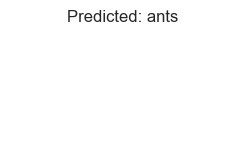

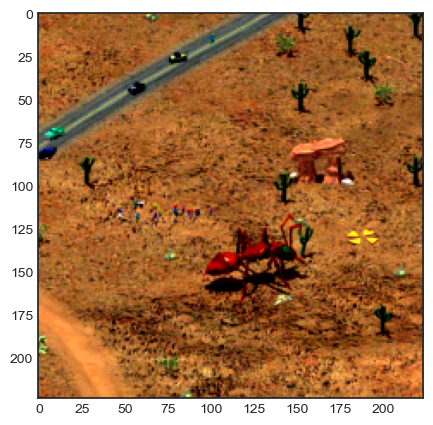

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


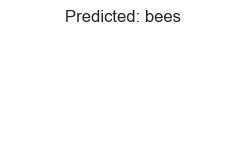

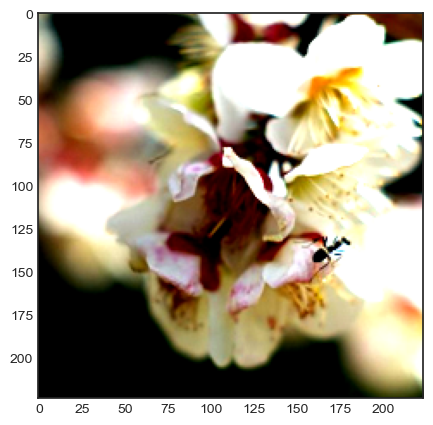

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


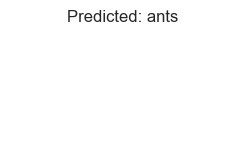

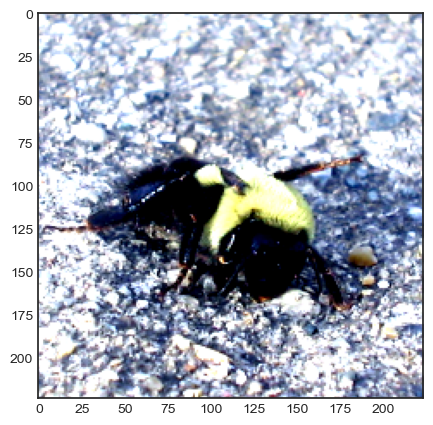

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


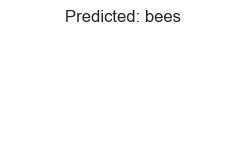

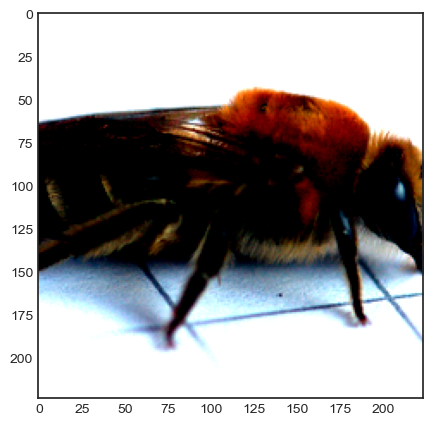

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


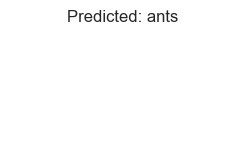

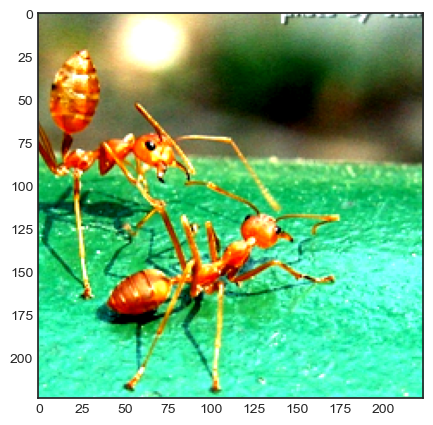

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


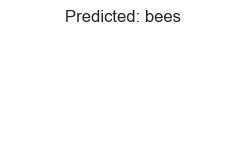

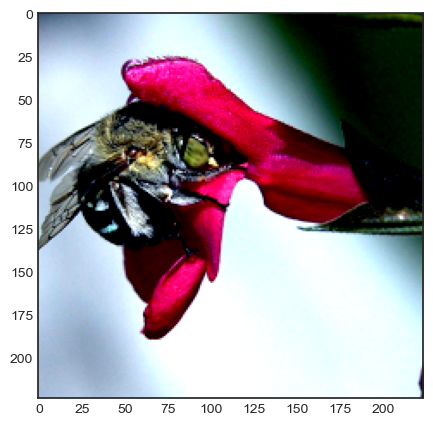

In [73]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [75]:
model_conv = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

for param in model_conv.parameters():
    param.requires_grad = False
    
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=1e-3, momentum=.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer_conv, step_size=7, gamma=.1)

In [76]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, 25)

Epoch: 1/25
----------
train Loss: 0.6035, Accuracy: 0.6762
val Loss: 0.1887, Accuracy: 0.9542

Epoch: 2/25
----------
train Loss: 0.4136, Accuracy: 0.8074
val Loss: 0.2325, Accuracy: 0.9216

Epoch: 3/25
----------
train Loss: 0.5700, Accuracy: 0.7418
val Loss: 0.1693, Accuracy: 0.9542

Epoch: 4/25
----------
train Loss: 0.5904, Accuracy: 0.7623
val Loss: 0.3489, Accuracy: 0.8627

Epoch: 5/25
----------
train Loss: 0.5370, Accuracy: 0.7787
val Loss: 0.1795, Accuracy: 0.9542

Epoch: 6/25
----------
train Loss: 0.4430, Accuracy: 0.8197
val Loss: 0.1878, Accuracy: 0.9412

Epoch: 7/25
----------
train Loss: 0.3897, Accuracy: 0.8320
val Loss: 0.1867, Accuracy: 0.9477

Epoch: 8/25
----------
train Loss: 0.3338, Accuracy: 0.8566
val Loss: 0.1908, Accuracy: 0.9477

Epoch: 9/25
----------
train Loss: 0.3590, Accuracy: 0.8525
val Loss: 0.1743, Accuracy: 0.9412

Epoch: 10/25
----------
train Loss: 0.4861, Accuracy: 0.8156
val Loss: 0.2405, Accuracy: 0.9150

Epoch: 11/25
----------
train Loss: 0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


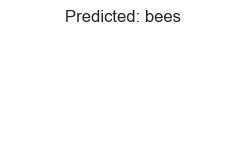

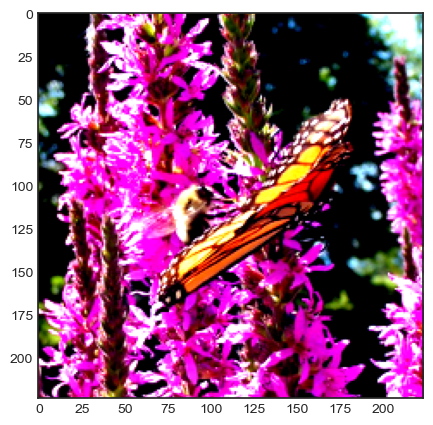

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


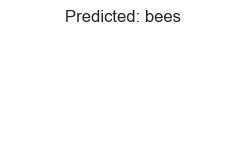

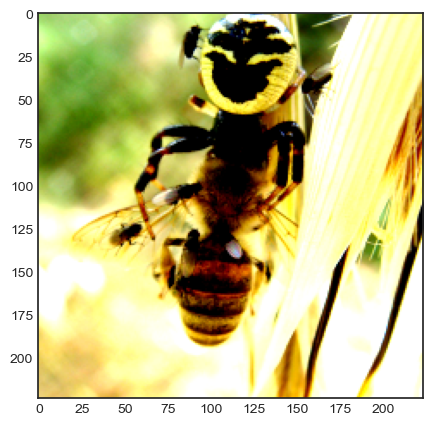

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


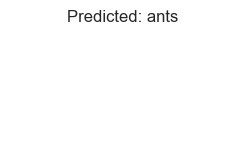

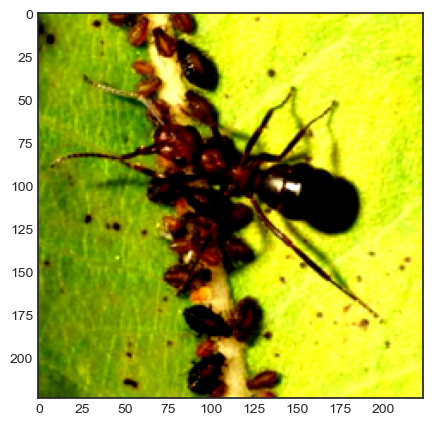

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


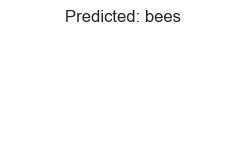

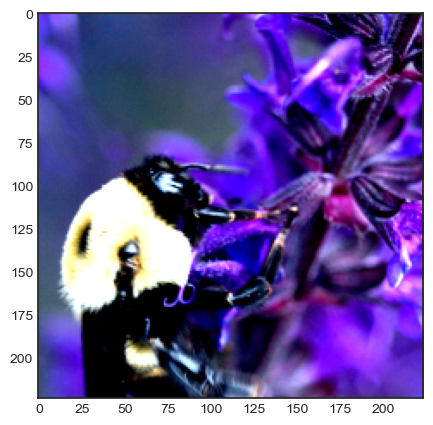

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


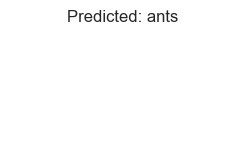

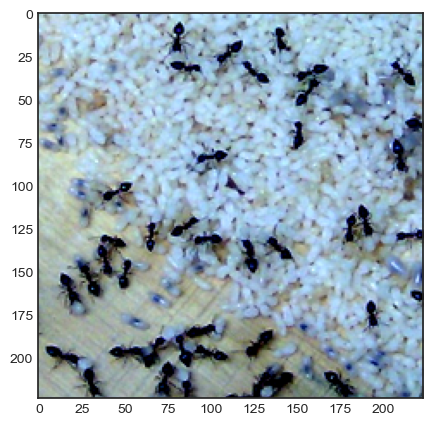

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


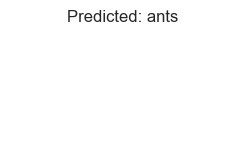

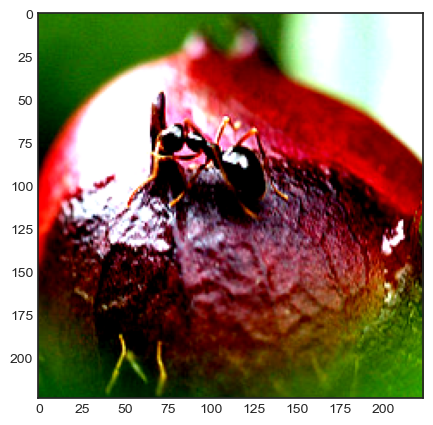

In [ ]:
visualize_model(model_ft)